In [1]:
# Intallation packages before use Jupyter

!pip install pandas
!pip install -U scikit-learn
!pip install keras
!pip install matplotlib
!pip install kaleido
!pip install plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 50.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 505.5/505.5 kB 50.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 kB 50.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 1.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 26.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 58.9 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 38.1 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 28.9 MB/s eta 0:00:0000:0100:01


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
# from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from math import sqrt
import matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# be able to save images on server
matplotlib.use('Agg')

# Not show warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# !pip install -U kaleido # w Google Colab wymagany Runtime restart po instalacji (Runtime -> Restart Runtime)
import kaleido #required
# kaleido.__version__ #0.2.1

print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


2024-06-19 10:14:56.226633: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.16.1
Num GPUs Available:  1


In [3]:
# Zip
# importing the "tarfile" module
import tarfile # type: ignore

# open file
file = tarfile.open('1_150x9.tar.gz')

# extracting a specific file
file.extractall(path='./1_150x9/')

file.close()

In [4]:
# Data generator
def data(time, features):
    # Timestep 
    # timestepsPerSample = 20
    timestepsPerSample = time

    # Timesteps in input data
    timestepsPerSampleWholeData = 150

    # Replace 'your_file.csv' with the actual file path
    file_features = './1_150x9/1_150x9f.csv'
    file_labels = './1_150x9/1_150x9l.csv'

    # Read the .csv file and create an array
    data_strings = np.genfromtxt(file_features, delimiter=';')
    labels_strings = np.genfromtxt(file_labels,delimiter=';')


    # Wycinanie wybranych kolumn
    #  0    1         2             3        4       5        6    7        8
    # RSI, VWAP, HeikenResult, closeHeiken, CMF, Stochastic, OBV, QQE, TrendFilter
    # data_s = data_strings[:,[0,2,3,4,5,6,7,8]]
    if features == 0:
        data_s = data_strings[:,[0,4,5,8]]
    elif features == 1:
        data_s = data_strings[:,[0,1,4,5,6,8]]
    elif features == 2:
        data_s = data_strings[:,:]
        
    num_features = data_s.shape[1]
    # print(data_strings[:3])
    # print(data_s[:3])

    
    # Convert from strings to float and int
    X = data_s.astype(float).reshape((-1,timestepsPerSampleWholeData,num_features))
    Y = labels_strings.astype(float).reshape((-1,3))
    # print(X.shape)
    # print(Y.shape)

    # Modification from imported to new size X[samples,timesteps]
    X_mod = X[1000:11000,timestepsPerSampleWholeData - timestepsPerSample:]
    Y_mod = Y[1000:11000]
    timestepsPerSampleWholeData = X_mod.shape[1]
    # print(X_mod.shape)
    # print(Y_mod.shape)
    # print(X_mod[:1])

    # Splitting
    x_train, x_test, Y_train, Y_test = train_test_split(X_mod,Y_mod, test_size=0.15, shuffle=False)
    y_train = Y_train[:, 0:2]
    y_test = Y_test[:, 0:2]
    # print(y_train[:2])
    # print(y_test[:2])

    # Summarize
    num_samples = x_train.shape[0]
    test_samples = x_test.shape[0]
    print(f"Train shape: {x_train.shape}")
    print(f"Timesteps: {timestepsPerSampleWholeData}")
    print(f"Num Samples: {num_samples}")
    print(f"Test Samples: {test_samples}")
    print(f"Num features: {num_features}")
    return x_train, x_test, y_train, y_test, Y_test

In [5]:
# fit lstm model
from tabnanny import verbose


def fit_lstmModel(x_train, y_train, x_test, y_test, batch_size, nb_epoch, neurons, denseType, dropout, model, learning_rate):
    if model == 0:
        model = Sequential()

        # Assuming `data` is your input matrix with shape (samples, time_steps, features)
        model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2])))
        model.add(Dropout(0.2))

        model.add(LSTM(units=50, return_sequences=False))
        model.add(Dropout(0.2))

        model.add(Dense(units=25))
        model.add(Dropout(0.2))

        # Output layer for price prediction
        model.add(Dense(y_train.shape[1], activation='sigmoid'))

    elif model == 1:
        model = Sequential()

        # Assuming `data` is your input matrix with shape (samples, time_steps, features)
        model.add(LSTM(units=150, return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2])))
        model.add(Dropout(0.2))

        model.add(LSTM(units=150, return_sequences=False))
        model.add(Dropout(0.2))

        model.add(Dense(units=75))
        model.add(Dropout(0.2))

        # Output layer for price prediction
        model.add(Dense(y_train.shape[1], activation='sigmoid'))

    elif model == 2:
        model = Sequential()

        # Assuming `data` is your input matrix with shape (samples, time_steps, features)
        model.add(LSTM(units=300, return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2])))
        model.add(Dropout(0.2))

        model.add(LSTM(units=300, return_sequences=False))
        model.add(Dropout(0.2))

        model.add(Dense(units=150))
        model.add(Dropout(0.2))

        # Output layer for price prediction
        model.add(Dense(y_train.shape[1], activation='sigmoid'))

    
    num_samples = x_train.shape[0]
    STEPS_PER_EPOCH = num_samples/batch_size

    # lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    0.001,
    decay_steps=STEPS_PER_EPOCH*100,
    decay_rate=0.9,
    staircase=False)

    # Callback EarlyStopping
    callback = EarlyStopping(monitor='val_loss',
                                             start_from_epoch=10,
                                             restore_best_weights=True,
                                             verbose=0,
                                             patience=5)

    def get_optimizer():
         # return tf.keras.optimizers.Adam(learning_rate=0.001)
        # return tf.keras.optimizers.Adam() # type: ignore
        return tf.keras.optimizers.RMSprop(learning_rate=learning_rate) # type: ignore
        # return tf.keras.optimizers.Adam(learning_rate= lr_schedule) # type: ignore

    optimizer = get_optimizer()

    # defining loss function, optimizer, metrics and then compiling model
    model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
    model.summary()

    # fit model
    history = model.fit(x_train, y_train, epochs=nb_epoch, batch_size=batch_size, 
                        shuffle=False, validation_data=(x_test, y_test), callbacks=callback, verbose=2) # type: ignore
    return model, history

In [6]:
# Profit
def funcProfit(predict, Y_test):
    predict_classes = np.where(predict > 0.5, 1,0)
    concat = np.hstack((predict_classes, Y_test[:,2:]))
    df = pd.DataFrame(concat, columns=['Sell', 'Buy', 'Price'])

    # Absolute difference prices
    sum = 0
    for i in range(0, len(df)):
        if (i-1) > 0:
            diff = abs((df.at[i,'Price'] - df.at[i-1,'Price']))
            if diff < 0.5:
                if df.at[i,'Sell'] == 1:
                    sum += (df.at[i,'Price'] - df.at[i-1,'Price'])*(-1)
                elif df.at[i,'Buy'] == 1:
                    sum += (df.at[i,'Price'] - df.at[i-1,'Price'])
                if df.at[i,'Sell'] != df.at[i-1,'Sell']:
                    sum -= 0.03
    return sum

In [7]:
# Experiment
def experiment(repeats, epochs, neurons, time, denseType, dropout, model, features, learning_rate):
    # Data gen
    x_train, x_test, y_train, y_test, Y_test = data(time, features)

    # Evaluate declaration
    accuracy = list()
    profit = list()
    metrics = list()

    # Repeats
    for r in range(repeats):
        print(f"Repeat {r} running...")
        # Batch size
        batch_size = 64
        # model
        model, history = fit_lstmModel(x_train, y_train, x_test, y_test, batch_size, epochs, neurons, denseType, dropout, model, learning_rate)

        # forecast the entire training dataset to build up state for forecasting
        predict = model.predict(x_test, batch_size=batch_size)
        test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0) # type: ignore

        metric = pd.DataFrame(history.history)
        metric['epoch'] = history.epoch

        metrics.append(metric)
        accuracy.append(test_acc*100)
        profit.append(funcProfit(predict, Y_test))
    
    return accuracy, profit, metrics

In [8]:
# Output
def plotsOut(d, metrics):
    fig = make_subplots(rows=1, cols=2, subplot_titles=('Accuracy', 'Loss'))

    # Layout - set size
    fig.update_layout(
        autosize=True,
        width=1000
    )

    for idx, m in enumerate(metrics):
        fig.add_trace(go.Scatter(x=m['epoch'], y=m['accuracy'], name=f'accuracy{str(idx)}', line_color='#0000ff', showlegend=False), row=1, col=1)
        fig.add_trace(go.Scatter(x=m['epoch'], y=m['loss'], name=f'loss{str(idx)}', line_color='#0000ff', showlegend=False), row=1, col=2)
        fig.add_trace(go.Scatter(x=m['epoch'], y=m['val_accuracy'], name=f'val_accuracy{str(idx)}', line_color='#EF8260', showlegend=False), row=1, col=1)
        fig.add_trace(go.Scatter(x=m['epoch'], y=m['val_loss'], name=f'val_loss{str(idx)}', line_color='#EF8260', showlegend=False), row=1, col=2)

    fig.update_xaxes(title_text='epochs')
    fig.update_yaxes(title_text='')
    # fig.update_layout(width=1000, title='Accuracy and Loss')
    fig.write_image(file=f"compare_models_{str(d)}.jpg", engine="kaleido")

In [9]:
# Run
from numpy import dtype

repeats = 4
results_acc = DataFrame(dtype='float')
results_profit = DataFrame(dtype='float')
metrics = list()

# vary training epochs
learning_rate = [0.001, 0.002, 0.005, 0.01]
features = 0
model = 0
dropout = 0.2
denseType = 0
neuronsLstm = 150
timeStep = 150
epochs = 100
for lr in learning_rate:
 print(f"{lr} Learning rate test start...")
 results_acc[str(lr)], results_profit[str(lr)], metrics = experiment(repeats, epochs, neuronsLstm, timeStep, denseType, dropout, model, features, lr)
 plotsOut(lr, metrics)

# summarize results
print(results_acc.describe())
print(results_profit.describe())

0.001 Learning rate test start...
Train shape: (8500, 150, 4)
Timesteps: 150
Num Samples: 8500
Test Samples: 1500
Num features: 4
Repeat 0 running...


2024-06-19 10:15:34.831534: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10393 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:0a:00.0, compute capability: 8.6
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 150, 50)        │        11,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 150, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            52 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,527 (127.06 KB)

 Trainable params: 32,527 (127.06 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


2024-06-19 10:15:37.007377: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906


133/133 - 6s - 44ms/step - accuracy: 0.6011 - loss: 0.6674 - val_accuracy: 0.6387 - val_loss: 0.6479
Epoch 2/100
133/133 - 3s - 19ms/step - accuracy: 0.6418 - loss: 0.6424 - val_accuracy: 0.6633 - val_loss: 0.6291
Epoch 3/100
133/133 - 3s - 19ms/step - accuracy: 0.6531 - loss: 0.6331 - val_accuracy: 0.6733 - val_loss: 0.6173
Epoch 4/100
133/133 - 3s - 19ms/step - accuracy: 0.6655 - loss: 0.6250 - val_accuracy: 0.6813 - val_loss: 0.6124
Epoch 5/100
133/133 - 3s - 19ms/step - accuracy: 0.6669 - loss: 0.6192 - val_accuracy: 0.6787 - val_loss: 0.6110
Epoch 6/100
133/133 - 3s - 19ms/step - accuracy: 0.6744 - loss: 0.6136 - val_accuracy: 0.6860 - val_loss: 0.6079
Epoch 7/100
133/133 - 3s - 19ms/step - accuracy: 0.6791 - loss: 0.6093 - val_accuracy: 0.6960 - val_loss: 0.5972
Epoch 8/100
133/133 - 3s - 19ms/step - accuracy: 0.6807 - loss: 0.6052 - val_accuracy: 0.7000 - val_loss: 0.5934
Epoch 9/100
133/133 - 3s - 20ms/step - accuracy: 0.6831 - loss: 0.5996 - val_accuracy: 0.7093 - val_loss: 0.

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 150, 50)        │        11,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 150, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            52 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,527 (127.06 KB)

 Trainable params: 32,527 (127.06 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
133/133 - 5s - 34ms/step - accuracy: 0.7078 - loss: 0.5766 - val_accuracy: 0.7253 - val_loss: 0.5682
Epoch 2/100
133/133 - 3s - 21ms/step - accuracy: 0.7026 - loss: 0.5754 - val_accuracy: 0.7273 - val_loss: 0.5629
Epoch 3/100
133/133 - 3s - 19ms/step - accuracy: 0.7045 - loss: 0.5748 - val_accuracy: 0.7240 - val_loss: 0.5667
Epoch 4/100
133/133 - 3s - 20ms/step - accuracy: 0.7044 - loss: 0.5772 - val_accuracy: 0.7247 - val_loss: 0.5657
Epoch 5/100
133/133 - 3s - 19ms/step - accuracy: 0.7056 - loss: 0.5735 - val_accuracy: 0.7207 - val_loss: 0.5661
Epoch 6/100
133/133 - 3s - 19ms/step - accuracy: 0.7072 - loss: 0.5733 - val_accuracy: 0.7200 - val_loss: 0.5684
Epoch 7/100
133/133 - 3s - 20ms/step - accuracy: 0.7026 - loss: 0.5757 - val_accuracy: 0.7233 - val_loss: 0.5654
Epoch 8/100
133/133 - 2s - 18ms/step - accuracy: 0.7079 - loss: 0.5700 - val_accuracy: 0.7220 - val_loss: 0.5633
Epoch 9/100
133/133 - 3s - 19ms/step - accuracy: 0.7065 - loss: 0.5711 - val_accuracy: 0.7173 - 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 150, 50)        │        11,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 150, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            52 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,527 (127.06 KB)

 Trainable params: 32,527 (127.06 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
133/133 - 4s - 32ms/step - accuracy: 0.7071 - loss: 0.5735 - val_accuracy: 0.7187 - val_loss: 0.5574
Epoch 2/100
133/133 - 3s - 20ms/step - accuracy: 0.7032 - loss: 0.5780 - val_accuracy: 0.7213 - val_loss: 0.5598
Epoch 3/100
133/133 - 2s - 18ms/step - accuracy: 0.7140 - loss: 0.5666 - val_accuracy: 0.7240 - val_loss: 0.5638
Epoch 4/100
133/133 - 3s - 19ms/step - accuracy: 0.7180 - loss: 0.5599 - val_accuracy: 0.7013 - val_loss: 0.5735
Epoch 5/100
133/133 - 3s - 20ms/step - accuracy: 0.7120 - loss: 0.5658 - val_accuracy: 0.7033 - val_loss: 0.5813
Epoch 6/100
133/133 - 2s - 18ms/step - accuracy: 0.7129 - loss: 0.5630 - val_accuracy: 0.7100 - val_loss: 0.5663
Epoch 7/100
133/133 - 2s - 17ms/step - accuracy: 0.7212 - loss: 0.5585 - val_accuracy: 0.7167 - val_loss: 0.5556
Epoch 8/100
133/133 - 3s - 20ms/step - accuracy: 0.7195 - loss: 0.5560 - val_accuracy: 0.6993 - val_loss: 0.5797
Epoch 9/100
133/133 - 2s - 19ms/step - accuracy: 0.7256 - loss: 0.5509 - val_accuracy: 0.7160 - 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 150, 50)        │        11,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 150, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            52 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,527 (127.06 KB)

 Trainable params: 32,527 (127.06 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
133/133 - 5s - 34ms/step - accuracy: 0.7254 - loss: 0.5415 - val_accuracy: 0.6880 - val_loss: 0.5987
Epoch 2/100
133/133 - 2s - 17ms/step - accuracy: 0.7385 - loss: 0.5348 - val_accuracy: 0.6907 - val_loss: 0.6048
Epoch 3/100
133/133 - 3s - 21ms/step - accuracy: 0.7325 - loss: 0.5437 - val_accuracy: 0.6940 - val_loss: 0.6112
Epoch 4/100
133/133 - 3s - 19ms/step - accuracy: 0.7260 - loss: 0.5421 - val_accuracy: 0.6973 - val_loss: 0.5932
Epoch 5/100
133/133 - 2s - 18ms/step - accuracy: 0.7365 - loss: 0.5370 - val_accuracy: 0.7047 - val_loss: 0.5950
Epoch 6/100
133/133 - 3s - 21ms/step - accuracy: 0.7376 - loss: 0.5375 - val_accuracy: 0.6980 - val_loss: 0.5852
Epoch 7/100
133/133 - 3s - 20ms/step - accuracy: 0.7372 - loss: 0.5410 - val_accuracy: 0.6893 - val_loss: 0.6140
Epoch 8/100
133/133 - 3s - 19ms/step - accuracy: 0.7385 - loss: 0.5344 - val_accuracy: 0.6947 - val_loss: 0.5979
Epoch 9/100
133/133 - 3s - 20ms/step - accuracy: 0.7514 - loss: 0.5178 - val_accuracy: 0.7000 - 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:205: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 150, 50)        │        11,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 150, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            52 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,527 (127.06 KB)

 Trainable params: 32,527 (127.06 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
133/133 - 5s - 36ms/step - accuracy: 0.6185 - loss: 0.6615 - val_accuracy: 0.6633 - val_loss: 0.6345
Epoch 2/100
133/133 - 2s - 17ms/step - accuracy: 0.6528 - loss: 0.6355 - val_accuracy: 0.6760 - val_loss: 0.6164
Epoch 3/100
133/133 - 3s - 21ms/step - accuracy: 0.6662 - loss: 0.6237 - val_accuracy: 0.6853 - val_loss: 0.6009
Epoch 4/100
133/133 - 3s - 22ms/step - accuracy: 0.6822 - loss: 0.6127 - val_accuracy: 0.7033 - val_loss: 0.5878
Epoch 5/100
133/133 - 2s - 18ms/step - accuracy: 0.6896 - loss: 0.6030 - val_accuracy: 0.7100 - val_loss: 0.5768
Epoch 6/100
133/133 - 3s - 20ms/step - accuracy: 0.6895 - loss: 0.5956 - val_accuracy: 0.7287 - val_loss: 0.5655
Epoch 7/100
133/133 - 3s - 21ms/step - accuracy: 0.6974 - loss: 0.5913 - val_accuracy: 0.7313 - val_loss: 0.5651
Epoch 8/100
133/133 - 2s - 18ms/step - accuracy: 0.6956 - loss: 0.5898 - val_accuracy: 0.7313 - val_loss: 0.5618
Epoch 9/100
133/133 - 3s - 19ms/step - accuracy: 0.6989 - loss: 0.5858 - val_accuracy: 0.7307 - 

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 150, 50)        │        11,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 150, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            52 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,527 (127.06 KB)

 Trainable params: 32,527 (127.06 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
133/133 - 5s - 38ms/step - accuracy: 0.7066 - loss: 0.5778 - val_accuracy: 0.7287 - val_loss: 0.5584
Epoch 2/100
133/133 - 3s - 20ms/step - accuracy: 0.7078 - loss: 0.5771 - val_accuracy: 0.7327 - val_loss: 0.5537
Epoch 3/100
133/133 - 2s - 19ms/step - accuracy: 0.7119 - loss: 0.5764 - val_accuracy: 0.7307 - val_loss: 0.5519
Epoch 4/100
133/133 - 3s - 20ms/step - accuracy: 0.7072 - loss: 0.5737 - val_accuracy: 0.7273 - val_loss: 0.5493
Epoch 5/100
133/133 - 2s - 19ms/step - accuracy: 0.7122 - loss: 0.5714 - val_accuracy: 0.7253 - val_loss: 0.5506
Epoch 6/100
133/133 - 3s - 20ms/step - accuracy: 0.7108 - loss: 0.5710 - val_accuracy: 0.7220 - val_loss: 0.5562
Epoch 7/100
133/133 - 3s - 19ms/step - accuracy: 0.7087 - loss: 0.5685 - val_accuracy: 0.7107 - val_loss: 0.5604
Epoch 8/100
133/133 - 3s - 20ms/step - accuracy: 0.7098 - loss: 0.5668 - val_accuracy: 0.7020 - val_loss: 0.5696
Epoch 9/100
133/133 - 3s - 20ms/step - accuracy: 0.7139 - loss: 0.5645 - val_accuracy: 0.7113 - 

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 150, 50)        │        11,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 150, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            52 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,527 (127.06 KB)

 Trainable params: 32,527 (127.06 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
133/133 - 4s - 33ms/step - accuracy: 0.7307 - loss: 0.5468 - val_accuracy: 0.7173 - val_loss: 0.5512
Epoch 2/100
133/133 - 2s - 17ms/step - accuracy: 0.7322 - loss: 0.5404 - val_accuracy: 0.7020 - val_loss: 0.5618
Epoch 3/100
133/133 - 3s - 22ms/step - accuracy: 0.7320 - loss: 0.5361 - val_accuracy: 0.6973 - val_loss: 0.5705
Epoch 4/100
133/133 - 3s - 20ms/step - accuracy: 0.7132 - loss: 0.5603 - val_accuracy: 0.7153 - val_loss: 0.5620
Epoch 5/100
133/133 - 2s - 18ms/step - accuracy: 0.7367 - loss: 0.5392 - val_accuracy: 0.6893 - val_loss: 0.5794
Epoch 6/100
133/133 - 3s - 21ms/step - accuracy: 0.7332 - loss: 0.5399 - val_accuracy: 0.6880 - val_loss: 0.5837
Epoch 7/100
133/133 - 3s - 20ms/step - accuracy: 0.7316 - loss: 0.5376 - val_accuracy: 0.7020 - val_loss: 0.5590
Epoch 8/100
133/133 - 3s - 19ms/step - accuracy: 0.7494 - loss: 0.5172 - val_accuracy: 0.6680 - val_loss: 0.6151
Epoch 9/100
133/133 - 3s - 21ms/step - accuracy: 0.7529 - loss: 0.5080 - val_accuracy: 0.6873 - 

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 150, 50)        │        11,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 150, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            52 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,527 (127.06 KB)

 Trainable params: 32,527 (127.06 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
133/133 - 4s - 32ms/step - accuracy: 0.7500 - loss: 0.5099 - val_accuracy: 0.6913 - val_loss: 0.5904
Epoch 2/100
133/133 - 2s - 18ms/step - accuracy: 0.7594 - loss: 0.4926 - val_accuracy: 0.6793 - val_loss: 0.6127
Epoch 3/100
133/133 - 3s - 20ms/step - accuracy: 0.7753 - loss: 0.4692 - val_accuracy: 0.6647 - val_loss: 0.6432
Epoch 4/100
133/133 - 2s - 18ms/step - accuracy: 0.7652 - loss: 0.4923 - val_accuracy: 0.6540 - val_loss: 0.7420
Epoch 5/100
133/133 - 3s - 20ms/step - accuracy: 0.7642 - loss: 0.4991 - val_accuracy: 0.6440 - val_loss: 0.6681
Epoch 6/100
133/133 - 3s - 20ms/step - accuracy: 0.7773 - loss: 0.4752 - val_accuracy: 0.6493 - val_loss: 0.6840
Epoch 7/100
133/133 - 2s - 19ms/step - accuracy: 0.7827 - loss: 0.4570 - val_accuracy: 0.6393 - val_loss: 0.6905
Epoch 8/100
133/133 - 3s - 22ms/step - accuracy: 0.7828 - loss: 0.4646 - val_accuracy: 0.6187 - val_loss: 0.7713
Epoch 9/100
133/133 - 2s - 19ms/step - accuracy: 0.7871 - loss: 0.4621 - val_accuracy: 0.6553 - 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:205: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 150, 50)        │        11,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 150, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │            52 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,527 (127.06 KB)

 Trainable params: 32,527 (127.06 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
133/133 - 5s - 36ms/step - accuracy: 0.6201 - loss: 0.6695 - val_accuracy: 0.6740 - val_loss: 0.6199
Epoch 2/100
133/133 - 2s - 18ms/step - accuracy: 0.6659 - loss: 0.6258 - val_accuracy: 0.7033 - val_loss: 0.5861
Epoch 3/100
133/133 - 3s - 21ms/step - accuracy: 0.6881 - loss: 0.6022 - val_accuracy: 0.7240 - val_loss: 0.5581
Epoch 4/100
133/133 - 3s - 20ms/step - accuracy: 0.6931 - loss: 0.5985 - val_accuracy: 0.7220 - val_loss: 0.5623
Epoch 5/100
133/133 - 2s - 18ms/step - accuracy: 0.6978 - loss: 0.5906 - val_accuracy: 0.7260 - val_loss: 0.5585
Epoch 6/100
133/133 - 3s - 21ms/step - accuracy: 0.6955 - loss: 0.5892 - val_accuracy: 0.7287 - val_loss: 0.5592
Epoch 7/100
133/133 - 3s - 22ms/step - accuracy: 0.6902 - loss: 0.6002 - val_accuracy: 0.7247 - val_loss: 0.5610
Epoch 8/100
133/133 - 2s - 18ms/step - accuracy: 0.7025 - loss: 0.5862 - val_accuracy: 0.7227 - val_loss: 0.5572
Epoch 9/100
133/133 - 3s - 21ms/step - accuracy: 0.7031 - loss: 0.5826 - val_accuracy: 0.7287 - 

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 150, 50)        │        11,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 150, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │            52 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,527 (127.06 KB)

 Trainable params: 32,527 (127.06 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
133/133 - 4s - 33ms/step - accuracy: 0.6995 - loss: 0.5864 - val_accuracy: 0.7233 - val_loss: 0.5472
Epoch 2/100
133/133 - 2s - 19ms/step - accuracy: 0.7082 - loss: 0.5742 - val_accuracy: 0.7313 - val_loss: 0.5479
Epoch 3/100
133/133 - 2s - 19ms/step - accuracy: 0.7082 - loss: 0.5757 - val_accuracy: 0.7267 - val_loss: 0.5535
Epoch 4/100
133/133 - 3s - 24ms/step - accuracy: 0.7055 - loss: 0.5785 - val_accuracy: 0.7200 - val_loss: 0.5474
Epoch 5/100
133/133 - 3s - 20ms/step - accuracy: 0.7076 - loss: 0.5776 - val_accuracy: 0.7320 - val_loss: 0.5468
Epoch 6/100
133/133 - 2s - 16ms/step - accuracy: 0.6968 - loss: 0.5900 - val_accuracy: 0.7280 - val_loss: 0.5562
Epoch 7/100
133/133 - 3s - 22ms/step - accuracy: 0.6813 - loss: 0.6091 - val_accuracy: 0.7133 - val_loss: 0.5755
Epoch 8/100
133/133 - 2s - 16ms/step - accuracy: 0.7056 - loss: 0.5831 - val_accuracy: 0.7093 - val_loss: 0.5619
Epoch 9/100
133/133 - 2s - 17ms/step - accuracy: 0.6984 - loss: 0.5832 - val_accuracy: 0.7107 - 

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 150, 50)        │        11,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 150, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │            52 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,527 (127.06 KB)

 Trainable params: 32,527 (127.06 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
133/133 - 4s - 33ms/step - accuracy: 0.7162 - loss: 0.5657 - val_accuracy: 0.7067 - val_loss: 0.5701
Epoch 2/100
133/133 - 3s - 20ms/step - accuracy: 0.7182 - loss: 0.5639 - val_accuracy: 0.7027 - val_loss: 0.5767
Epoch 3/100
133/133 - 3s - 19ms/step - accuracy: 0.7109 - loss: 0.5716 - val_accuracy: 0.7093 - val_loss: 0.5650
Epoch 4/100
133/133 - 3s - 19ms/step - accuracy: 0.7161 - loss: 0.5654 - val_accuracy: 0.7173 - val_loss: 0.5616
Epoch 5/100
133/133 - 3s - 22ms/step - accuracy: 0.7226 - loss: 0.5542 - val_accuracy: 0.7040 - val_loss: 0.5735
Epoch 6/100
133/133 - 2s - 16ms/step - accuracy: 0.7208 - loss: 0.5592 - val_accuracy: 0.7060 - val_loss: 0.5722
Epoch 7/100
133/133 - 3s - 21ms/step - accuracy: 0.7216 - loss: 0.5576 - val_accuracy: 0.7073 - val_loss: 0.5649
Epoch 8/100
133/133 - 3s - 20ms/step - accuracy: 0.7182 - loss: 0.5607 - val_accuracy: 0.7073 - val_loss: 0.5608
Epoch 9/100
133/133 - 3s - 20ms/step - accuracy: 0.7355 - loss: 0.5435 - val_accuracy: 0.7000 - 

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 150, 50)        │        11,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 150, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │            52 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,527 (127.06 KB)

 Trainable params: 32,527 (127.06 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
133/133 - 5s - 35ms/step - accuracy: 0.7421 - loss: 0.5376 - val_accuracy: 0.6887 - val_loss: 0.5924
Epoch 2/100
133/133 - 2s - 16ms/step - accuracy: 0.7420 - loss: 0.5234 - val_accuracy: 0.6987 - val_loss: 0.5809
Epoch 3/100
133/133 - 3s - 21ms/step - accuracy: 0.7468 - loss: 0.5273 - val_accuracy: 0.6980 - val_loss: 0.5850
Epoch 4/100
133/133 - 3s - 19ms/step - accuracy: 0.7538 - loss: 0.5107 - val_accuracy: 0.7067 - val_loss: 0.5915
Epoch 5/100
133/133 - 2s - 18ms/step - accuracy: 0.7673 - loss: 0.4892 - val_accuracy: 0.6560 - val_loss: 0.6279
Epoch 6/100
133/133 - 3s - 20ms/step - accuracy: 0.7729 - loss: 0.4813 - val_accuracy: 0.6680 - val_loss: 0.6370
Epoch 7/100
133/133 - 3s - 20ms/step - accuracy: 0.7768 - loss: 0.4779 - val_accuracy: 0.6793 - val_loss: 0.6256
Epoch 8/100
133/133 - 3s - 20ms/step - accuracy: 0.7835 - loss: 0.4677 - val_accuracy: 0.6560 - val_loss: 0.6728
Epoch 9/100
133/133 - 2s - 17ms/step - accuracy: 0.7791 - loss: 0.4643 - val_accuracy: 0.6753 - 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:205: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 150, 50)        │        11,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 150, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │            52 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,527 (127.06 KB)

 Trainable params: 32,527 (127.06 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
133/133 - 4s - 34ms/step - accuracy: 0.6368 - loss: 0.6674 - val_accuracy: 0.6973 - val_loss: 0.6103
Epoch 2/100
133/133 - 2s - 18ms/step - accuracy: 0.6738 - loss: 0.6306 - val_accuracy: 0.7160 - val_loss: 0.5730
Epoch 3/100
133/133 - 3s - 20ms/step - accuracy: 0.6893 - loss: 0.6138 - val_accuracy: 0.7233 - val_loss: 0.5597
Epoch 4/100
133/133 - 3s - 20ms/step - accuracy: 0.6906 - loss: 0.6029 - val_accuracy: 0.7280 - val_loss: 0.5652
Epoch 5/100
133/133 - 3s - 19ms/step - accuracy: 0.6958 - loss: 0.5990 - val_accuracy: 0.7187 - val_loss: 0.5634
Epoch 6/100
133/133 - 3s - 22ms/step - accuracy: 0.6979 - loss: 0.5970 - val_accuracy: 0.7207 - val_loss: 0.5688
Epoch 7/100
133/133 - 3s - 19ms/step - accuracy: 0.7013 - loss: 0.5914 - val_accuracy: 0.7227 - val_loss: 0.5652
Epoch 8/100
133/133 - 3s - 19ms/step - accuracy: 0.7020 - loss: 0.5886 - val_accuracy: 0.7227 - val_loss: 0.5657
Epoch 9/100
133/133 - 3s - 22ms/step - accuracy: 0.6998 - loss: 0.5904 - val_accuracy: 0.7207 - 

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 150, 50)        │        11,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 150, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │            52 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,527 (127.06 KB)

 Trainable params: 32,527 (127.06 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
133/133 - 5s - 35ms/step - accuracy: 0.7053 - loss: 0.5850 - val_accuracy: 0.7160 - val_loss: 0.5582
Epoch 2/100
133/133 - 3s - 21ms/step - accuracy: 0.7098 - loss: 0.5765 - val_accuracy: 0.7220 - val_loss: 0.5480
Epoch 3/100
133/133 - 3s - 19ms/step - accuracy: 0.7158 - loss: 0.5703 - val_accuracy: 0.7167 - val_loss: 0.5565
Epoch 4/100
133/133 - 2s - 19ms/step - accuracy: 0.7205 - loss: 0.5681 - val_accuracy: 0.7133 - val_loss: 0.5738
Epoch 5/100
133/133 - 3s - 19ms/step - accuracy: 0.7104 - loss: 0.5813 - val_accuracy: 0.7160 - val_loss: 0.5659
Epoch 6/100
133/133 - 3s - 19ms/step - accuracy: 0.7213 - loss: 0.5746 - val_accuracy: 0.7347 - val_loss: 0.5366
Epoch 7/100
133/133 - 3s - 21ms/step - accuracy: 0.7258 - loss: 0.5601 - val_accuracy: 0.7073 - val_loss: 0.5753
Epoch 8/100
133/133 - 3s - 19ms/step - accuracy: 0.7255 - loss: 0.5551 - val_accuracy: 0.7027 - val_loss: 0.6147
Epoch 9/100
133/133 - 2s - 19ms/step - accuracy: 0.7376 - loss: 0.5483 - val_accuracy: 0.7060 - 

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 150, 50)        │        11,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 150, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │            52 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,527 (127.06 KB)

 Trainable params: 32,527 (127.06 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
133/133 - 5s - 36ms/step - accuracy: 0.7373 - loss: 0.5485 - val_accuracy: 0.7007 - val_loss: 0.6092
Epoch 2/100
133/133 - 3s - 19ms/step - accuracy: 0.7492 - loss: 0.5296 - val_accuracy: 0.6753 - val_loss: 0.6003
Epoch 3/100
133/133 - 3s - 22ms/step - accuracy: 0.7341 - loss: 0.5530 - val_accuracy: 0.6947 - val_loss: 0.5999
Epoch 4/100
133/133 - 2s - 17ms/step - accuracy: 0.7473 - loss: 0.5336 - val_accuracy: 0.7067 - val_loss: 0.5830
Epoch 5/100
133/133 - 3s - 22ms/step - accuracy: 0.7534 - loss: 0.5204 - val_accuracy: 0.6800 - val_loss: 0.6541
Epoch 6/100
133/133 - 3s - 21ms/step - accuracy: 0.7542 - loss: 0.5115 - val_accuracy: 0.6920 - val_loss: 0.6225
Epoch 7/100
133/133 - 2s - 18ms/step - accuracy: 0.7627 - loss: 0.5165 - val_accuracy: 0.6920 - val_loss: 0.6193
Epoch 8/100
133/133 - 3s - 20ms/step - accuracy: 0.7684 - loss: 0.4997 - val_accuracy: 0.6820 - val_loss: 0.6363
Epoch 9/100
133/133 - 3s - 20ms/step - accuracy: 0.7556 - loss: 0.5207 - val_accuracy: 0.6760 - 

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 150, 50)        │        11,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 150, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │            52 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,527 (127.06 KB)

 Trainable params: 32,527 (127.06 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
133/133 - 4s - 32ms/step - accuracy: 0.7482 - loss: 0.5445 - val_accuracy: 0.6947 - val_loss: 0.5816
Epoch 2/100
133/133 - 2s - 19ms/step - accuracy: 0.7621 - loss: 0.5096 - val_accuracy: 0.6720 - val_loss: 0.6218
Epoch 3/100
133/133 - 3s - 19ms/step - accuracy: 0.7519 - loss: 0.5245 - val_accuracy: 0.6927 - val_loss: 0.6108
Epoch 4/100
133/133 - 3s - 19ms/step - accuracy: 0.7281 - loss: 0.5637 - val_accuracy: 0.6893 - val_loss: 0.5726
Epoch 5/100
133/133 - 3s - 22ms/step - accuracy: 0.7467 - loss: 0.5343 - val_accuracy: 0.7067 - val_loss: 0.5937
Epoch 6/100
133/133 - 3s - 19ms/step - accuracy: 0.7191 - loss: 0.5598 - val_accuracy: 0.7173 - val_loss: 0.5818
Epoch 7/100
133/133 - 2s - 19ms/step - accuracy: 0.7324 - loss: 0.5545 - val_accuracy: 0.6873 - val_loss: 0.6113
Epoch 8/100
133/133 - 3s - 21ms/step - accuracy: 0.7315 - loss: 0.5595 - val_accuracy: 0.6767 - val_loss: 0.5936
Epoch 9/100
133/133 - 2s - 18ms/step - accuracy: 0.7347 - loss: 0.5526 - val_accuracy: 0.7253 - 

In [10]:
# summarize results
print(results_acc.describe())
print(results_profit.describe())

           0.001      0.002      0.005       0.01
count   4.000000   4.000000   4.000000   4.000000
mean   71.399999  70.116666  70.716666  69.750001
std     1.617499   3.727129   2.823907   2.778421
min    69.199997  65.333331  66.799998  66.000003
25%    70.799997  68.083332  69.649997  68.750000
50%    71.699998  70.899999  71.433333  70.199999
75%    72.299999  72.933333  72.500001  71.200000
max    73.000002  73.333335  73.199999  72.600001
         0.001     0.002     0.005      0.01
count  4.00000  4.000000  4.000000  4.000000
mean  -2.69750 -4.080000 -1.605000 -3.417500
std    0.85574  1.400809  2.940867  3.092587
min   -3.60000 -5.730000 -4.770000 -5.630000
25%   -3.24750 -4.620000 -3.195000 -5.420000
50%   -2.77500 -4.140000 -1.935000 -4.545000
75%   -2.22500 -3.600000 -0.345000 -2.542500
max   -1.64000 -2.310000  2.220000  1.050000


           0.001      0.002      0.005       0.01
count   4.000000   4.000000   4.000000   4.000000
mean   71.399999  70.116666  70.716666  69.750001
std     1.617499   3.727129   2.823907   2.778421
min    69.199997  65.333331  66.799998  66.000003
25%    70.799997  68.083332  69.649997  68.750000
50%    71.699998  70.899999  71.433333  70.199999
75%    72.299999  72.933333  72.500001  71.200000
max    73.000002  73.333335  73.199999  72.600001


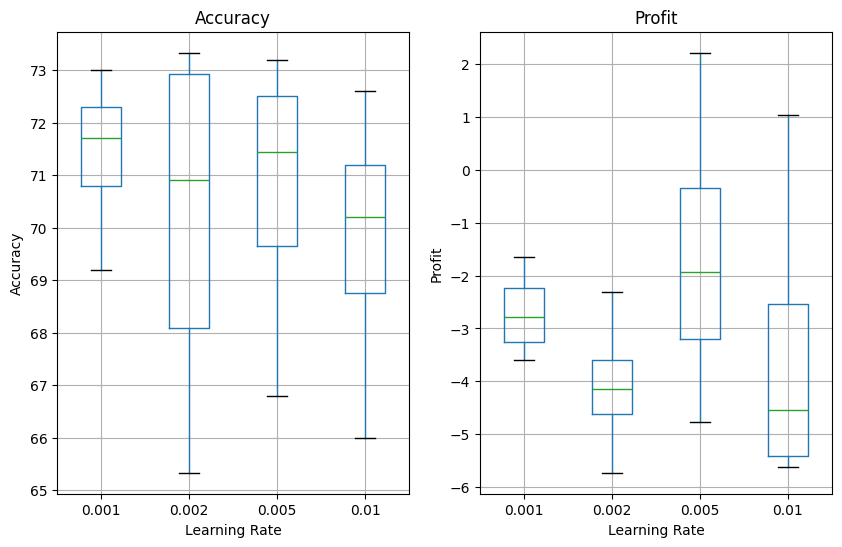

In [11]:
%matplotlib inline
print(results_acc.describe())

# 2 subplots in one row
fig, ax = plt.subplots(1, 2, figsize=(10, 6))

# Generate boxplots
results_acc.boxplot(ax=ax[0])
results_profit.boxplot(ax=ax[1])

# Set labels and titles
ax[0].set_title('Accuracy')
ax[0].set_xlabel('Learning Rate')
ax[0].set_ylabel('Accuracy')
ax[1].set_title('Profit')
ax[1].set_xlabel('Learning Rate')
ax[1].set_ylabel('Profit')

# Save to .png and show plot
plt.savefig(f'boxplot_learning_rate.png')
plt.show()